# SWIFT Planet orientation for collision sim initial conditions
(BETA - UNDER CONSTRUCTION)

This notebook reads in a target and impactor planet and places them within a SWIFT initial conditions file with the specified impact velocity, angle/parameter, and time to collision.

Adriana Postema ([anpostema@ucdavis.edu](mailto:anpostema@ucdavis.edu))

## Instructions:
Use the output thermal profile .txt files from the makeplanet_SWIFT_share and the resulting final snapshot of your SWIFT initialization runs as inputs for this notebook.

This notebook will use the WoMa functions for calculating initial positions and velocity vectors given an impact angle, impact velocity, and time to collision. **These prefer to be calculated from the analytic profiles given in the thermal profile .txt file but can be calculated just from the relaxed SPH bodies if necessary**. This is so the velocity and positions imparted to the SPH bodies are consistent across resolutions (ie, the planet will receive the same center of mass position when built with 10^5 particles as with 10^7).

In [1]:
import sys
import os
import inspect
import importlib

# This version of WoMa can initialize a planet with entropy
this_dir = os.path.abspath('')
path = os.path.join(this_dir)
sys.path.append(path)
#print(sys.path)

import woma
import numpy as np
import h5py
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from swiftsimio.objects import cosmo_array
import scipy
from scipy import interpolate

import swiftsimio as sw

from woma.misc import glob_vars as gv
from woma.eos import sesame
from woma.eos.T_rho import T_rho
from woma.misc import utils, io

from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as local_cmaps
from copy import deepcopy
%run eostable.py

import gadget_sph
importlib.reload(gadget_sph)


#print(inspect.getfile(woma))


# MAKE SURE YOU ARE USING THE SAME VALUES AS WOMA AND SWIFT!
R_earth = gv.R_earth#6.371e6   # m
M_earth = gv.M_earth#5.9724e24  # kg
Gmks = gv.G #6.67408e-11  # m^3 kg^-1 s^-2
Rcmb = 3480000. # CMB radius in m (from PREM)
# Declare some standard variables
#G = 6.67E-11 # Gravitational constant  m3/kg/s2
G = Gmks*1.e3
Mearth = 5.972E27 # Earth's mass g
Rearth = 6371.E5  # Earth's radius cm
Rcmb = 348000000. # CMB radius in cm (from PREM)

woma.load_eos_tables()


In [2]:
eospath = '../'
# load iron EOS model

def loadEOS(eos='Iron-ANEOS-SLVTv0.2G1'):
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

    if eos == 'Iron-ANEOS-SLVTv0.2G1':
        eosdir = eospath + 'aneos-iron-2020/'

        MODELNAME = 'Iron-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 191105.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.2      # ANEOS Parameters Version number
        FMN = 26.          # Formula weight in atomic numbers for Fe
        FMW = 55.847       # Formula molecular weight (g/cm3) for Fe
        # The following define the default initial state for material in the 201 table
        R0REF   = 8.06     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
        K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below

    elif eos == 'Fe85Si15-ANEOS-SLVTv0.2G1':
        eosdir = eospath + 'aneos-Fe85Si15-2020/'
        # ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
        MODELNAME = 'Fe85Si15-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 191105.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.2      # ANEOS Parameters Version number
        FMN = 24.20        # Formula weight in atomic numbers for Fe85Si15
        FMW = 51.68        # Formula molecular weight (g/cm3) for Fe85Si15
        # The following define the default initial state for material in the 201 table
        R0REF   = 7.51     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
        K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
        #-------------------------------------------------------------

    elif eos == 'Forsterite-ANEOS-SLVTv1.0G1':
        eosdir = eospath + 'aneos-forsterite-2019/'
        MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 190802.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.1      # ANEOS Parameters Version number
        FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
        FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
        # The following define the default initial state for material in the 201 table
        R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
        K0REF   = 1.1E12   # dynes/cm2
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
        
    elif eos == 'Pyrolite-ANEOS-SLVTv0.2G1':
        eosdir = eospath + '/aneos-pyrolite-2022//'
        MODELNAME = 'Pyrolite-ANEOS-SLVTv0.2G1'
        # Header information must all be compatible with float format
        MATID = 1.0        # MATID number
        DATE = 210627.     # Date as a single 6-digit number YYMMDD
        VERSION = 0.1      # ANEOS Parameters Version number
        FMN = 153.          # Formula weight in atomic numbers for Mg2SiO4
        FMW = 3234.61      # Formula molecular weight (g/cm3) for Mg2SiO4
        # The following define the default initial state for material in the 201 table
        R0REF   = 3.35     # g/cm3 *** R0REF is inserted into the density array
        K0REF   = 0.95E12  # dynes/cm2
        T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
        P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
    
    
    
    NewEOS  = extEOStable() # FIRST make new empty EOS object
    NewEOS.loadextsesame(eosdir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.loadstdsesame(eosdir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
    NewEOS.MODELNAME = MODELNAME # string set above in user input
    NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
    #print(NewEOS.units) # these are the default units for SESAME rho-T tables
    #'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

    # Add the header info to the table. This could be done during the loading. 
    # if made from this notebook, these values are set in the user-input above.
    # ** MAKE SURE THEY MATCH ANEOS.INPUT **
    NewEOS.MATID   = MATID
    NewEOS.DATE    = DATE
    NewEOS.VERSION = VERSION
    NewEOS.FMN     = FMN
    NewEOS.FMW     = FMW
    NewEOS.R0REF   = R0REF
    NewEOS.K0REF   = K0REF
    NewEOS.T0REF   = T0REF
    NewEOS.P0REF   = P0REF
    #
    # Load the information from ANEOS.INPUT and ANEOS.OUTPUT
    NewEOS.loadaneos(aneosinfname=eosdir+'ANEOS.INPUT',aneosoutfname=eosdir+'ANEOS.OUTPUT',silent=True)
    #
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
    #
    # calculate the 1-bar profile; loop over temp
    NewEOS.onebar.T = np.zeros(NewEOS.NT)
    NewEOS.onebar.S = np.zeros(NewEOS.NT)
    NewEOS.onebar.rho = np.zeros(NewEOS.NT)
    it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
    id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
    for iit in range(0,NewEOS.NT):
        NewEOS.onebar.T[iit] = NewEOS.T[iit]
        NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
        NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

    return NewEOS

IronEOS = loadEOS(eos='Iron-ANEOS-SLVTv0.2G1')
AlloyEOS = loadEOS(eos='Fe85Si15-ANEOS-SLVTv0.2G1')
ForsteriteEOS = loadEOS(eos='Forsterite-ANEOS-SLVTv1.0G1')
PyroliteEOS = loadEOS(eos='Pyrolite-ANEOS-SLVTv0.2G1')

In [3]:
### DELETE
# load iron-alloy EOS model

datadir = eospath + 'aneos-Fe85Si15-2020/'
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Fe85Si15-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 191105.     # Date as a single 6-digit number YYMMDD
VERSION = 0.2      # ANEOS Parameters Version number
FMN = 24.20        # Formula weight in atomic numbers for Fe85Si15
FMW = 51.68        # Formula molecular weight (g/cm3) for Fe85Si15
# The following define the default initial state for material in the 201 table
R0REF   = 7.51     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#-------------------------------------------------------------

NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

AlloyEOS = deepcopy(NewEOS)

In [4]:
## DEL
# load forsterite EOS model

datadir = eospath + 'aneos-forsterite-2019/'
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below

NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

ForsteriteEOS = deepcopy(NewEOS)


In [5]:
# load pyrolite EOS model
# SET LOCAL PATH TO https://github.com/ststewart/aneos-pyrolite-2022/releases/tag/v0.2.0
datadir = eospath + 'aneos-pyrolite-2022/'

# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------

MODELNAME = 'Pyrolite-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 210627.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 153          # Formula weight in atomic numbers for NaCa2Fe4Mg30Al3Si24O89 left out Na and added 1 Si
FMW = 3234.61      # Formula molecular weight (g/mol) for NaCa2Fe4Mg30Al3Si24O89
# The following define the default initial state for material in the 201 table
R0REF   = 3.35     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 0.95E12  # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below



NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame(datadir+'NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame(datadir+'NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname=datadir+'ANEOS.INPUT',aneosoutfname=datadir+'ANEOS.OUTPUT',silent=True)
#
NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,silent=True)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])

PyroliteEOS = deepcopy(NewEOS)



In [6]:
class planet_profile:
    def __init__(self,file=None):
        self.M = 0.
        self.cf = 0.
        self.R = 0.
        self.rarr = np.array([])
        self.density = np.array([])
        self.pressure = np.array([])
        self.temperature = np.array([])
        self.energy = np.array([])
        self.entropy = np.array([])
        self.mat = np.array([])
        self.mass = np.array([])
        self.units = 'cgs'
        self.file=file
        if file is not None:
            self.load(file)
        
    def load(self,file='profile.txt'):
        self.file=file
        self.rarr,self.density,self.temperature,self.pressure,self.energy,self.entropy,self.mass,self.mat=np.loadtxt(file,skiprows=1,unpack=True)
        self.M=self.mass[-1]
        self.R=self.rarr[-1]
        
    def convert_to_mks(self):
        if self.units!='mks':
            self.rarr = self.rarr * 1.e-2            #cm to m
            self.density = self.density * 1.e3       #g/cm^3 to kg/m^3
            self.pressure = self.pressure * 1.e-1    #dyne/cm^2 to Pa
            self.energy = self.energy * 1.e-4        #erg/g to J/kg
            self.entropy = self.entropy * 1.e-4      #erg/g/K to J/kg/K
            self.mass = self.mass * 1.e-3            #g to kg
            self.M = self.mass[-1]
            self.R=self.rarr[-1]
            self.units = 'mks'
            
    def convert_to_cgs(self):
        if self.units!='cgs':
            self.rarr = self.rarr * 1.e2            #m to cm
            self.density = self.density * 1.e-3       #kg/m^3 to g/cm^3
            self.pressure = self.pressure * 1.e1    #Pa to dyne/cm^2
            self.energy = self.energy * 1.e4        #J/kg to erg/g
            self.entropy = self.entropy * 1.e4      #J/kg/K to erg/g/K
            self.mass = self.mass * 1.e3            #kg to g
            self.M = self.mass[-1]
            self.R=self.rarr[-1]
            self.units = 'cgs'
            
    def write(self,file='profile.txt'):
        self.convert_to_cgs()
        with open(file,"w") as outfile: # open the file for writing
            outfile.write("#radius[cm] density[g/cm^3] temperature[K] pressure[dyne/cm^2] sp.energy[erg/g] sp.entropy[erg/g/K] menclosed[g] matID\n")
            for i in range(0,len(self.rarr)):
                outfile.write("{:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:.8e} {:g}\n".format(self.rarr[i],self.density[i],self.temperature[i],self.pressure[i],self.energy[i],self.entropy[i],self.mass[i],self.mat[i]))
        

In [7]:
# ALL OF THIS IS IN MKS
class snapshot:
    def __init__(self,filename,plot=False,init=True):
        self.file=filename
        self.data = sw.load(filename)
        self.data.gas.coordinates.convert_to_mks()
        self.data.gas.pressures.convert_to_mks()
        self.data.gas.internal_energies.convert_to_mks()
        self.data.gas.masses.convert_to_mks()
        self.data.gas.velocities.convert_to_mks()
        self.data.gas.smoothing_lengths.convert_to_mks()
        self.data.gas.densities.convert_to_mks()
        self.data.gas.potentials.convert_to_mks()
        #self.data.gas.entropies.convert_to_mks()
        
        self.part_id = self.data.gas.particle_ids.value
        self.u = self.data.gas.internal_energies.value
        if init: self.u_s = self.data.gas.get_internal_energies.value * R_earth**2
        self.rho = self.data.gas.densities.value
        self.pres = self.data.gas.pressures.value
        self.mat_id = self.data.gas.material_ids.value
        self.pot = self.data.gas.potentials.value
        self.m = self.data.gas.masses.value
        self.h = self.data.gas.smoothing_lengths.value
        if init: self.s_fixed = self.data.gas.entropies.value* R_earth**2
        
        self.time = self.data.metadata.time.in_mks()
        self.box_size_nonmks = self.data.metadata.boxsize
        self.box_size = self.data.metadata.boxsize.in_mks()
        self.pos = self.data.gas.coordinates
        self.vel = self.data.gas.velocities
        self.rrr = np.sqrt((self.pos.value[:,0]-self.box_size.value[0]/2.)**2 + (self.pos.value[:,1]-self.box_size.value[1]/2.)**2 + (self.pos.value[:,2]-self.box_size.value[2]/2.)**2)
        self.vvv = np.sqrt((self.vel.value[:,0])**2 + (self.vel.value[:,1])**2 + (self.vel.value[:,2])**2)
        
        self.N = len(self.rho)
        self.s = np.zeros(self.N)
        self.T = np.zeros(self.N)
        self.T_fixed = np.zeros(self.N)
        self.u_calc = np.zeros(self.N)
        
        for i in range(self.N):
            # these functions want MKS input values
            self.s[i]=sesame.s_u_rho(self.u[i],self.rho[i],self.mat_id[i])
            self.T[i]=sesame.T_rho_s(self.rho[i],self.s[i],self.mat_id[i])
            if init: self.T_fixed[i]=sesame.T_rho_s(self.rho[i],self.s_fixed[i],self.mat_id[i])
            if init: self.u_calc[i]=sesame.u_s_rho(self.s_fixed[i],self.rho[i],self.mat_id[i])
        
        if plot:
            plt.scatter(self.pos[:,0]/R_earth,self.pos[:,1]/R_earth,s=1)
            plt.xlabel('Distance (R_earth)')
            plt.ylabel('Distance (R_earth)')
            plt.gca().set_aspect('equal')
            plt.gca().set_xlim(None,None)
            plt.gca().set_ylim(None,None)
            plt.show()
            
            
    def datacopy(self):
        return deepcopy(self.data)
        

In [8]:
def plot_relax_model_profiles(snapshot,planet=None,title=''):
    if planet is None:
        planet=planet_profile() #just adding a null planet so plots don't error
    planet.convert_to_mks()

    fir, ax = plt.subplots(2, 3, figsize=(12,8))
    fir.suptitle(title,fontsize=20)
    
    ax[0, 0].scatter(snapshot.rrr/R_earth,snapshot.rho,s=2,label='SPH particles')
    ax[0, 0].plot(planet.rarr/R_earth, planet.density, label='Planet model',color='black')
    ax[0, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 0].set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax[0, 0].set_yscale("log")
    ax[0, 0].set_xlim(0, None)
    ax[0, 0].set_title("Time %06d s" % snapshot.time.value)
    
    ax[1, 0].scatter(snapshot.rrr/R_earth, snapshot.vvv,s=2)
    ax[1, 0].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 0].set_ylabel(r"Velocities, [m/s]")
    ax[1, 0].set_xlim(0, None)
    ax[1, 0].set_ylim(0, None)
    
    ax[0, 1].scatter(snapshot.rrr/R_earth, snapshot.pres/1.e9,s=2)
    ax[0, 1].plot(planet.rarr/R_earth, planet.pressure/1.E9, label='Planet model',color='black')
    ax[0, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 1].set_ylabel(r"Pressure, $P$ [GPa]")
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_xlim(0, None)
    ax[0, 1].set_ylim(0.01, None)
    ax[0, 1].set_title("SPH N=%i" % snapshot.N)

    ax[1, 2].scatter(snapshot.rrr/R_earth, snapshot.u/1.e6,s=2)
    ax[1, 2].plot(planet.rarr/R_earth, planet.energy/1.e6, label='Planet model',color='black')
    ax[1, 2].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 2].set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax[1, 2].set_xlim(0, None)
    ax[1, 2].set_ylim(0, None)

    ax[0, 2].scatter(snapshot.rrr/R_earth, snapshot.s/1.e3,s=2)
    ax[0, 2].plot(planet.rarr/R_earth, planet.entropy/1.e3, label='Planet model',color='black')
    ax[0, 2].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 2].set_ylabel(r"Sp. Entropy, $S$ [kJ/K/kg]")
    ax[0, 2].set_xlim(0, None)
    ax[0, 2].set_ylim(0, None)
    ax[0, 2].set_title("SPH mass=%04f $[M_\oplus]$"%(np.sum(snapshot.m)/M_earth)+"\n"+"Planet mass=%04f $[M_\oplus]$"% (planet.M/M_earth))

    ax[1, 1].scatter(snapshot.rrr/R_earth, snapshot.T,s=2)
    ax[1, 1].plot(planet.rarr/R_earth, planet.temperature, label='Planet model',color='black')
    ax[1, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[1, 1].set_ylabel(r"Temperature, $T$ [K]")
    ax[1, 1].set_xlim(0, None)
    ax[1, 1].set_ylim(0, None)
    
    ax[0,0].legend(fontsize=8)
   
    plt.tight_layout()


In [9]:
def plot_mantle_phase_profiles(snapshot,planet=None,mantlemat=400,title=''):
    if planet is None:
        planet=planet_profile() #just adding a null planet so plots don't error
    planet.convert_to_mks()

    if mantlemat==400:
        mantleEOS=ForsteriteEOS
    if mantlemat==403:
        mantleEOS=PyroliteEOS
    indmantle=np.where(snapshot.mat_id==mantlemat)
    
    fir, ax = plt.subplots(2, 3, figsize=(12,8))
    fir.suptitle(title,fontsize=20)
    
    ax[0, 0].scatter(snapshot.pres[indmantle]/1.e9,snapshot.rho[indmantle],s=2,label='SPH particles')
    ax[0, 0].plot(planet.pressure/1.e9, planet.density, label='Planet model',color='black')
    ax[0, 0].plot(mantleEOS.mc.Pl,mantleEOS.mc.rl*1.e3, label='Liquidus',color='blue')
    ax[0, 0].plot(mantleEOS.mc.Ps,mantleEOS.mc.rs*1.e3, label='Solidus',color='red')
    ax[0, 0].set_xlabel(r"Pressure,  $P$ [GPa]")
    ax[0, 0].set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax[0, 0].set_yscale("log")
    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(None, 2.e1)
    ax[0, 0].set_ylim(None,1.e4)
    ax[0, 0].set_title("Time %06d s" % snapshot.time.value)
    
    ax[1, 0].scatter(snapshot.pres/1.e9, 1/snapshot.rho,s=2)
    ax[1, 0].plot(planet.pressure/1.E9,1/planet.density, label='Planet model',color='black')
    ax[1, 0].plot(mantleEOS.mc.Pl,1/(mantleEOS.mc.rl*1.e3), label='Liquidus',color='blue')
    ax[1, 0].plot(mantleEOS.mc.Ps,1/(mantleEOS.mc.rs*1.e3), label='Solidus',color='red')
    ax[1, 0].set_xlabel(r"Pressure,  $P$ [GPa]")
    ax[1, 0].set_ylabel(r"Specific Volume, $V$ [m$^{3}/kg$]")
    ax[1, 0].set_xlim(None,2.e1)
    ax[1, 0].set_ylim(1.e-4,None)
    ax[1, 0].set_yscale("log")
    ax[1, 0].set_xscale("log")
    ax[1, 0].set_xlim(None, None)
    ax[1, 0].set_ylim(0, None)
    
    ax[0, 1].scatter(snapshot.rrr[indmantle]/R_earth, snapshot.pres[indmantle]/1.e9,s=2)
    ax[0, 1].plot(planet.rarr/R_earth, planet.pressure/1.E9, label='Planet model',color='black')
    ax[0, 1].set_xlabel(r"Radius, $r$ $[R_\oplus]$")
    ax[0, 1].set_ylabel(r"Pressure, $P$ [GPa]")
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_xlim(0.125, None)
    ax[0, 1].set_ylim(0.00001, None)
    ax[0, 1].set_title("SPH N=%i" % snapshot.N)

    ax[1, 2].scatter(snapshot.pres[indmantle]/1.e9, snapshot.u[indmantle]/1.e6,s=2, label='SPH particles')
    ax[1, 2].scatter(snapshot.pres[indmantle]/1.e9, snapshot.u_calc[indmantle]/1.e6,s=2, label='Calculated U (SWIFT)')
    ax[1, 2].plot(planet.pressure/1.E9, planet.energy/1.e6, label='Planet model',color='black')
    ax[1, 2].plot(mantleEOS.mc.Pl,mantleEOS.mc.Ul, label='Liquidus',color='blue')
    ax[1, 2].plot(mantleEOS.mc.Ps,mantleEOS.mc.Us, label='Solidus',color='red')
    ax[1, 2].set_xlabel(r"Pressure,  $P$ [GPa]")
    ax[1, 2].set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax[1, 2].set_xscale("log")
    ax[1, 2].set_xlim(None, 2.e1)
    ax[1, 2].set_ylim(0, 4.5)
    ax[1, 2].legend(fontsize=8)

    ax[0, 2].scatter(snapshot.pres[indmantle]/1.e9, snapshot.s_fixed[indmantle]/1.e3,s=2, label='SPH particles')
    ax[0, 2].scatter(snapshot.pres[indmantle]/1.e9, snapshot.s[indmantle]/1.e3,s=2, label='Calculated S')
    ax[0, 2].plot(planet.pressure/1.E9, planet.entropy/1.e3, label='Planet model',color='black')
    ax[0, 2].plot(mantleEOS.mc.Pl,mantleEOS.mc.Sl*1.e3, label='Liquidus',color='blue')
    ax[0, 2].plot(mantleEOS.mc.Ps,mantleEOS.mc.Ss*1.e3, label='Solidus',color='red')
    ax[0, 2].set_xlabel(r"Pressure,  $P$ [GPa]")
    ax[0, 2].set_ylabel(r"Sp. Entropy, $S$ [kJ/K/kg]")
    ax[0 ,2].set_xscale("log")
    ax[0, 2].set_xlim(None, 2.e1)
    ax[0, 2].set_ylim(0, None)
    ax[0, 2].set_title("SPH mass=%04f $[M_\oplus]$"%(np.sum(snapshot.m)/M_earth)+"\n"+"Planet mass=%04f $[M_\oplus]$"% (planet.M/M_earth))
    ax[0, 2].legend(fontsize=8)

    ax[1, 1].scatter(snapshot.pres[indmantle]/1.e9, snapshot.T_fixed[indmantle],s=2,label='SPH particles')
    ax[1, 1].scatter(snapshot.pres[indmantle]/1.e9, snapshot.T[indmantle],s=2,label='Calculated T')
    ax[1, 1].plot(planet.pressure/1.E9, planet.temperature, label='Planet model',color='black')
    ax[1, 1].plot(mantleEOS.mc.Pl,mantleEOS.mc.T, label='Liquidus',color='blue')
    ax[1, 1].plot(mantleEOS.mc.Ps,mantleEOS.mc.T, label='Solidus',color='red')
    ax[1, 1].set_xlabel(r"Pressure,  $P$ [GPa]")
    ax[1, 1].set_ylabel(r"Temperature, $T$ [K]")
    ax[1, 1].set_xscale('log')
    ax[1, 1].set_xlim(None, 2.e1)
    ax[1, 1].set_ylim(2000, 3000)
    ax[1, 1].legend(fontsize=8)
    
    ax[0,0].legend(fontsize=8)
   
    plt.tight_layout()
    
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.u[indmantle]/1.e6,s=4, label='U (from fixed-entropy SPH particles)')
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.u_s[indmantle]/1.e6,s=2, label='U (from SWIFT-calculated energy)')
    ax.plot(planet.pressure/1.E9, planet.energy/1.e6, label='Planet model',color='black')
    ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.Ul, label='Liquidus',color='blue')
    ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.Us, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax.set_xscale("log")
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2.6, 3.0)
    ax.legend(fontsize=8)
    plt.tight_layout
    
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.scatter(snapshot.rho[indmantle], snapshot.u[indmantle]/1.e6,s=4, label='U (from fixed-entropy SPH particles)')
    ax.scatter(snapshot.rho[indmantle], snapshot.u_calc[indmantle]/1.e6,s=2, label='U (from WoMa-calculated energy)')
    ax.plot(planet.density, planet.energy/1.e6, label='Planet model',color='black')
    ax.plot(mantleEOS.mc.rl*1.e3,mantleEOS.mc.Ul, label='Liquidus',color='blue')
    ax.plot(mantleEOS.mc.rs*1.e3,mantleEOS.mc.Us, label='Solidus',color='red')
    ax.set_xlabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax.set_ylabel(r"Sp. Internal Energy, $U$ [MJ/kg]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(3.e3, 3.1e3)
    ax.set_ylim(2.6, 3.0)
    ax.legend(fontsize=8)
    plt.tight_layout
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.T_fixed[indmantle],s=2,label='T (from fixed-entropy SPH particles)')
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.T[indmantle],s=2,label='T (from calculated entropy)')
    ax.plot(planet.pressure/1.E9, planet.temperature, label='Planet model',color='black')
    ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.T, label='Liquidus',color='blue')
    ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.T, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Temperature, $T$ [K]")
    ax.set_xscale('log')
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2100, 2300)
    ax.legend(fontsize=8)
   
    plt.tight_layout()
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    #ax.plot(planet.pressure/1.E9, planet.entropy/1.e3, label='Planet model',color='black')
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.s_fixed[indmantle]/1.e3,s=2, label='Fixed Entropy')
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.s[indmantle]/1.e3,s=2, label='Calculated S from U and rho')
    ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.Sl*1.e3, label='Liquidus',color='blue')
    ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.Ss*1.e3, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Sp. Entropy, $S$ [kJ/K/kg]")
    ax.set_xscale("log")
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(2.7, 3.0)
    ax.legend(fontsize=8)
    plt.tight_layout()
    
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.plot(planet.pressure/1.E9, planet.density, label='Planet model',color='black')
    ax.scatter(snapshot.pres[indmantle]/1.e9, snapshot.rho[indmantle],s=2, label='SPH particles')
    ax.plot(mantleEOS.mc.Pl,mantleEOS.mc.rl*1.e3, label='Liquidus',color='blue')
    ax.plot(mantleEOS.mc.Ps,mantleEOS.mc.rs*1.e3, label='Solidus',color='red')
    ax.set_xlabel(r"Pressure,  $P$ [GPa]")
    ax.set_ylabel(r"Density, $\rho$ [kg m$^{-3}$]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(None, 2.e1)
    ax.set_ylim(3e3, 3.1e3)
    ax.legend(fontsize=8)
    plt.tight_layout()

In [10]:
def orientPlanets(filename,b=45,v_c=1,t=3600,target=None,targetSPH=None,projectile=None,projSPH=None,units_b="B",units_v_c="v_esc",plot=True,verbose=True,boxsize=80*R_earth,densityfloor=None,hmax=None,rVel=True,saveoutput=True):
    # check if analytic profiles are provided, if not use SPH attributes
    if target is not None:    
        target.convert_to_mks()
        M_t = target.M
        R_t = target.R
    else:
        M_t = np.sum(targetSPH.m)
        R_t = np.amax(targetSPH.rrr)
    if projectile is not None:
        projectile.convert_to_mks()
        M_i = projectile.M
        R_i = projectile.R
    else:
        M_i = np.sum(projSPH.m)
        R_i = np.amax(projSPH.rrr)
    
    if verbose:
        print('Target Radius (R_earth) and Mass (M_earth): ',R_t/R_earth, M_t/M_earth)
        print('Projectile Radius (R_earth) and Mass (M_earth): ',R_i/R_earth, M_i/M_earth)

    # Mutual escape speed
    v_esc = np.sqrt(2 * Gmks * (M_t + M_i) / (R_t + R_i))
    print('v_esc [m/s]=',v_esc)
    if units_v_c == 'v_esc':
        vc=v_c
        vkms=vc/1.e3*v_esc
    elif units_v_c == 'm/s':
        vc=v_c/v_esc
        vkms=v_c/1.e3
    
    A1_pos_t = np.array([0., 0., 0.])
    A1_vel_t = np.array([0., 0., 0.])
    A1_vel_i = np.array([0., 0., 0.])

    # get initial position and velocity of the impactor
    # Set time until contact in second below
    # Instead: impact angle in degrees and speed in units of the escape speed
    A1_pos_i, A1_vel_i = woma.impact_pos_vel_b_v_c_t(
        b           = b,
        v_c         = v_c, 
        t           = t, 
        R_t         = R_t, 
        R_i         = R_i, 
        M_t         = M_t, 
        M_i         = M_i,
        units_b     = units_b, 
        units_v_c   = units_v_c,
    )
    
    if verbose:
        print('Initial positions, velocities (target then impactor)')
        print(A1_pos_t / R_earth, "R_earth")
        print(A1_pos_i / R_earth, "R_earth")
        print(A1_vel_t, "m/s")
        print(A1_vel_i, "m/s")
    
    # Centre of mass
    A1_pos_com = (M_t * A1_pos_t + M_i * A1_pos_i) / (M_t + M_i)
    A1_pos_t -= A1_pos_com
    A1_pos_i -= A1_pos_com
    # Centre of momentum
    A1_vel_com = (M_t * A1_vel_t + M_i * A1_vel_i) / (M_t + M_i)
    A1_vel_t -= A1_vel_com
    A1_vel_i -= A1_vel_com
    
    if verbose:
        print('Center of Mass positions and velocities')
        print('COM = ',A1_pos_com / R_earth)
        print(A1_pos_t / R_earth, "R_earth")
        print(A1_vel_t, "m/s")
        print(A1_pos_i / R_earth, "R_earth")
        print(A1_vel_i, "m/s")
    
    # give the two bodies their COM positions and velocities in the middle of the spatial domain
    tpos = targetSPH.pos.value+A1_pos_t-targetSPH.box_size.value/2
    ppos = projSPH.pos.value+A1_pos_i-projSPH.box_size.value/2
    
    # include residual velocities from initialization (tends to produce better angular momentum conservation)
    if rVel==True:
        tvel = targetSPH.vel.value+A1_vel_t
        pvel = projSPH.vel.value+A1_vel_i
    else:
        tvel = np.zeros([targetSPH.N,3])+A1_vel_t
        pvel = np.zeros([projSPH.N,3])+A1_vel_i
    
    if plot:
        plt.scatter(tpos[:,0]/R_earth,tpos[:,1]/R_earth,s=1)
        plt.scatter(ppos[:,0]/R_earth,ppos[:,1]/R_earth,s=1)
        plt.xlabel('Distance (R_earth)')
        plt.ylabel('Distance (R_earth)')
        plt.gca().set_aspect('equal')

    if verbose:
        # check the velocities
        print('Target (m/s)')
        print('Vx min, max',np.min(tvel[:,0]),np.max(tvel[:,0]))
        print('Vy min, max',np.min(tvel[:,1]),np.max(tvel[:,1]))
        print('Vz min, max',np.min(tvel[:,2]),np.max(pvel[:,2]))
        print('Projectile (m/s)')
        print('Vx min, max',np.min(pvel[:,0]),np.max(pvel[:,0]))
        print('Vy min, max',np.min(pvel[:,1]),np.max(pvel[:,1]))
        print('Vz min, max',np.min(pvel[:,2]),np.max(pvel[:,2]))

    # set the id numbers
    t_pid =np.arange(targetSPH.N)
    p_pid =np.arange(projSPH.N)+9000000
    
    #set h_max to a density floor (in R_earth units)
    h_max=None
    if densityfloor is not None:
        h_max=np.power((3/4*np.amin([np.amin(targetSPH.m),np.amin(projSPH.m)])/densityfloor/np.pi),1/3)/R_earth
        print('Specified density floor: ',densityfloor*1.e-3,'[g/cm^3]')
        print('Resulting h_max: ',h_max,'[R_earth]')
    elif hmax is not None:
        h_max=hmax
        densityfloor=3/4*np.amin([np.amin(targetSPH.m),np.amin(projSPH.m)])/np.pi/((h_max*R_earth)**3)
        print('Specified h_max: ',h_max,'[R_earth]')
        print('Resulting density floor: ',densityfloor*1.e-3,'[g/cm^3]')
    
    
    # first check if file exists; if so, delete it
    if (os.path.isfile(filename)):
        input("Output file name exists already; press enter to delete it and write new file: "+filename)
        !del -f $filename
        
    with h5py.File(filename, "w") as f:
        io.save_particle_data(
            f,
            np.append(tpos, ppos, axis=0),
            np.append(tvel, pvel, axis=0),
            np.append(targetSPH.m, projSPH.m),
            np.append(targetSPH.h, projSPH.h),
            np.append(targetSPH.rho, projSPH.rho),
            np.append(targetSPH.pres, projSPH.pres),
            np.append(targetSPH.u, projSPH.u),
            np.append(targetSPH.mat_id, projSPH.mat_id),
            A1_id=np.append(t_pid, p_pid),
            A1_s=np.append(targetSPH.s, projSPH.s),
            boxsize=boxsize,
            file_to_SI=woma.Conversions(M_earth, R_earth, 1), # mass, length, time
        )
        if h_max is not None:
            f['Header'].attrs.modify('h_max_override',h_max)
        
    # write planet profiles to text file
    # assuming a filename ending with .hdf5
    if saveoutput:
        outtxtname=''.join(np.char.add(filename.split('.')[:-1],'.'))+'txt'
        with open(outtxtname,"w") as outfile: # open the file for writing
            outfile.write("#filename M_t[M_earth] M_i[M_earth] R_t[R_earth] R_i[R_earth] b B[degrees] v/vesc v[km/s] t_impact[sec] h_max[R_earth] density_floor[g/cm^3] box_size[R_earth] TargetSPH Target_profile ImpactorSPH Impactor_profile ResidualVels \n")
            outfile.write('{:s} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8e} {:f} {:f} {:.8e} {:.8f} {:s} {:s} {:s} {:s} {:b}'.format(filename,M_t/M_earth,M_i/M_earth,R_t/R_earth,R_i/R_earth,np.sin(b*np.pi/180),b,vc,vkms,t,h_max,densityfloor/1.e3,boxsize/R_earth,targetSPH.file,target.file,projSPH.file,projectile.file,rVel))
        print('Saved ',outtxtname)
    else:
        outstring='{:s} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8e} {:f} {:f} {:.8e} {:.8f} {:s} {:s} {:s} {:s} {:b}'.format(filename,M_t/M_earth,M_i/M_earth,R_t/R_earth,R_i/R_earth,np.sin(b*np.pi/180),b,vc,vkms,t,h_max,densityfloor/1.e3,boxsize/R_earth,targetSPH.file,target.file,projSPH.file,projectile.file,rVel)
        return outstring

In [11]:
def relax_ICs(filename,SPH,rvel=True,boxsize=80*R_earth):
    if rvel==True:
        SPHvel = SPH.vel.value
    else:
        SPHvel = np.zeros([SPH.N,3])

    if (os.path.isfile(filename)):
        input("Output file name exists already; press enter to delete it and write new file: "+filename)
        !del -f $filename
        
    with h5py.File(filename, "w") as f:
        io.save_particle_data(
            f,
            SPH.pos.value-SPH.box_size.value/2,
            SPHvel,
            SPH.m,
            SPH.h,
            SPH.rho,
            SPH.pres,
            SPH.u,
            SPH.mat_id,
            A1_s=SPH.s,
            boxsize=boxsize,
            file_to_SI=woma.Conversions(M_earth, R_earth, 1), # mass, length, time
        )

# Loading Planets
Load the SWIFT relaxation snapshot and the analytic planet profile from MakePlanets_iterative for both target and projectile. 

This routine will run if no analytic profile is provided, but analytic profiles are greatly preferred for orientation and proper impact parameter calculation.

## Load target

In [12]:
def loadPlanet(snapshotname,profilename=None,plot=False,init=True):
    planetSPH = snapshot(snapshotname,plot=plot,init=init)
    planetdata = planetSPH.datacopy()
    if profilename is not None:
        profile = planet_profile(profilename)
    else:
        profile=None
    return planetSPH,profile,planetdata

In [14]:
# Load target SWIFT hdf5 file
filename = "M0.5PyroSCwarmSMwarmN1330_0012.hdf5"
# Load target MakePlanets profile text file
txtfile = "M0.5PyroSCwarmSMwarmN133_fulltension.txt"

targetSPH,targetplanet,targetdata = loadPlanet(filename,txtfile)

Could not find gas gamma, assuming 5./3.


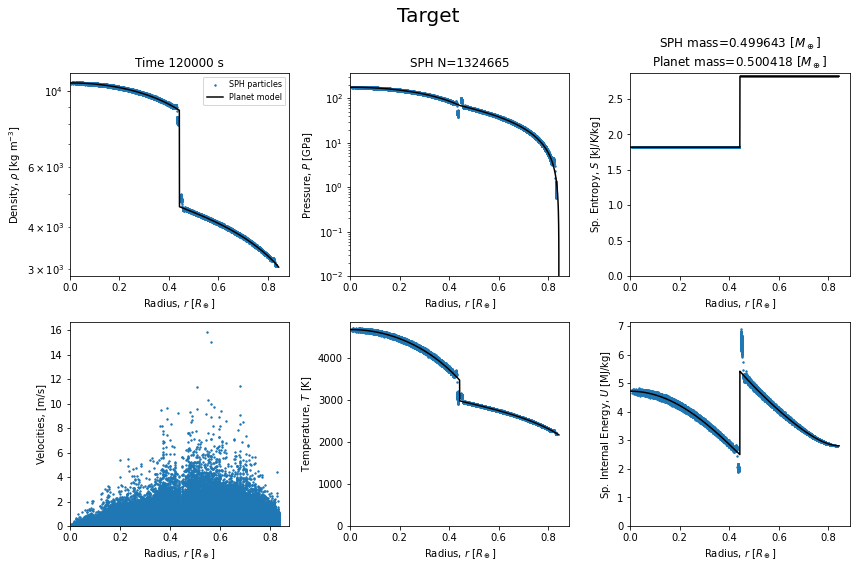

In [15]:
plot_relax_model_profiles(targetSPH,targetplanet,title='Target')
#plot_mantle_phase_profiles(targetSPH,targetplanet,mantlemat=403)

## Load projectile

In [16]:
# Load SWIFT hdf5 file
filename = "M.25PyroSCwarmSMwarmN670_0012.hdf5"
# Load MakePlanets profile text file
txtfile = "M.25PyroSCwarmSMwarmN67_fulltension.txt"
#del projSPH,projplanet,projdata
projSPH,projplanet,projdata = loadPlanet(filename,txtfile)

Could not find gas gamma, assuming 5./3.


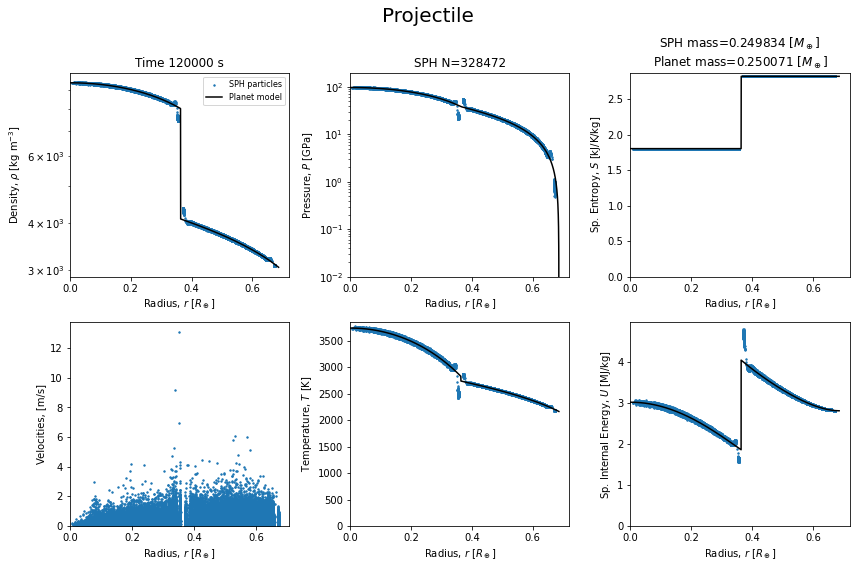

In [17]:
plot_relax_model_profiles(projSPH,projplanet,title='Projectile')
#plot_mantle_phase_profiles(projSPH,projplanet,mantlemat=403)

## Optional: make output files for secondary relaxation steps
Uses final snapshots from initial relaxation runs to create ICs files for secondary relaxation runs (such as running a second relaxation without velocity damping etc)

Note: DOUBLE CHECK TO MAKE SURE THE SMOOTHING LENGTHS ARE CORRECT! They should be on the order of 0.01 to 0.001 (in R_Earth units). If they're seemingly extremely small, just reload the relaxation snapshots and then run this cell immediately after.

In [51]:
targetfile = "M0.91PyroSCwarmSMwarmN133_novdamp.hdf5"
projfile = "M0.455PyroSCwarmSMwarmN67_novdamp.hdf5"
relax_ICs(targetfile,targetSPH,rvel=False)
#relax_ICs(projfile,projSPH)

Output file name exists already; press enter to delete it and write new file: M0.91PyroSCwarmSMwarmN133_novdamp.hdf5

num_particle = 138678
boxsize      = 80
mat_id       = 402 403 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [39.025, 40.975,    39.025, 40.975,    39.024, 40.975]
  vel = [0, 0,    0, 0,    0, 0]
  m = 6.5479e-06, 6.6091e-06
  rho = 0.13602, 0.52173
  P = 2.3834e-09, 3.3774e-07
  u = 6.2194e-08, 2.368e-07
  h = 0.028735, 0.044937
  s = 4.4735e-11, 6.948e-11

Saved "M0.91PyroSCwarmSMwarmN133_novdamp.hdf5"


# Orient planets for impact
Parameters:
 - `filename` - Output filename for SWIFT ICs hdf5 file
 - `b` - Impact angle or parameter (depending on `units_b`)
 - `v_c` - Impact velocity in units of v_esc or m/s (depending on `units_v_c`)
 - `target` - .txt file of the target planet's initial profile - for more accurately calculating impact times and angles
 - `targetSPH` - SPH snapshot object from `loadPlanet()` (see cells that load target and projectile snapshots)
 - `projectile` - .txt file of projectile's initial profile - for more accurately calculating impact times and angles
 - `projSPH` - SPH snapshot object from `loadplanet()`
 - `units_b` - units for impact angle/parameter input, `B` for angle (in degrees) or `b` for impact parameter
 - `units_v_c` - units for impact velocity input, `v_esc` for scaled to escape velocity, `m/s` for m/s
 - `boxsize` - size of SWIFT SPH simulation confining box (in mks units)
 - `densityfloor` - minimum desired density for SPH particles that have reached the maximum smoothing length (in mks units). This takes priority over `hmax`. In a real simulation, the minimum attained density will be slightly larger than this value due to something complicated about the kernel function and interpolated density field. 
 - `hmax` - maximum smoothing length for the simulation (in R_earth units). `densityfloor` overrides this input.
 
 Note: the `densityfloor` and `hmax` parameters will print out text in the output that specifies what h_max to use in the SWIFT yaml parameter files. This code will also set an hdf5 header attribute titled `h_max_override` that will enable SWIFT to ignore the h_max value set in the yaml file in favor of using that value specified in the hdf5 header, though this only works if a git patch is applied to your local SWIFT repo. If the git patch is not applied this extra header attribute does nothing.

Target Radius (R_earth) and Mass (M_earth):  0.8434668074085702 0.5004180781595339
Projectile Radius (R_earth) and Mass (M_earth):  0.6858380144404332 0.25007144364074746
v_esc [m/s]= 7836.220183022337
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[5.27256031 0.35605494 0.        ] R_earth
[0. 0. 0.] m/s
[-6063.71043018   897.43274734     0.        ] m/s
Center of Mass positions and velocities
COM =  [1.75687565 0.11864146 0.        ]
[-1.75687565 -0.11864146  0.        ] R_earth
[2020.49565923 -299.03455835    0.        ] m/s
[3.51568465 0.23741348 0.        ] R_earth
[-4043.21477095   598.39818899     0.        ] m/s
Target (m/s)
Vx min, max 2011.13759457806 2031.1613496516075
Vy min, max -307.3365622113057 -288.1753302166768
Vz min, max -9.784494400024414 5.128993988037109
Projectile (m/s)
Vx min, max -4048.627643265536 -4032.3806234977746
Vy min, max 591.7811016276836 602.3995951846599
Vz min, max -5.674066066741943 5.128993988037109
Specified density floo

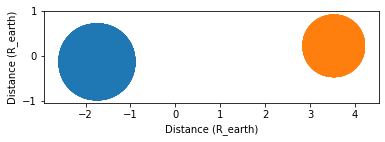

In [17]:
# Collision parameters
b = 30.               #impact angle/parameter
v_c = 1.15               #impact velocity (in units of v_esc or m/s)
t = 3600               #time to impact (in seconds)
units_b = "B"          #"B" for angle, "b" for parameter
units_v_c = "v_esc"    #"v_esc" for scaled to escape velocity, "m/s" for m/s
boxsize = 5000*R_earth
densityfloor = 1.e-1   #kg/m^3
hmax=None

filename = 'halfearth0.5x0.25v1.15th45N1e6.hdf5'         #hdf5 filename

orientPlanets(filename,b=b,v_c=v_c,t=t,target=targetplanet,targetSPH=targetSPH,projectile=projplanet,projSPH=projSPH,units_b=units_b,units_v_c=units_v_c,boxsize=boxsize,densityfloor=densityfloor,hmax=hmax)

## Build multiple collisions from an input file:
See testOrientation.txt for an example of input formatting; this routine expects a header row. This routine will write an output file (with a specified name) with a line for each input containing the same information as the standard .txt outputs. 

Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.24646038455501493 0.010007283755274262
Projectile Radius (R_earth) and Mass (M_earth):  0.196122884947418 0.004999976776505257
v_esc [m/s]= 2059.8450748685705
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[0.87928021 0.01040453 0.        ] R_earth
[0. 0. 0.] m/s
[-1042.10893201  1024.47184615     0.        ] m/s
Center of Mass positions and velocities
COM =  [0.29295024 0.00346648 0.        ]
[-0.29295024 -0.00346648  0.        ] R_earth
[ 347.19997348 -341.32381643    0.        ] m/s
[0.58632997 0.00693805 0.        ] R_earth
[-694.90895853  683.14802972    0.        ] m/s
Target (m/s)
Vx min, max 345.5711515122869 348.7044025832632
Vy min, max -342.94976021480016 -339.6239026946967
Vz min, max -1.5987048149108887 1.7521734237670898
Projectile (m/s)
Vx min, max -696.5647219208411 -693.387943485134
Vy min, max 680.5638679578597 684.5

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.5172520844451421 0.10006790670417252
Projectile Radius (R_earth) and Mass (M_earth):  0.41534689216763465 0.050025178320273256
v_esc [m/s]= 4487.6008082467415
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[2.04610454 0.01731138 0.        ] R_earth
[0. 0. 0.] m/s
[-2593.10769406  2125.71641702     0.        ] m/s
Center of Mass positions and velocities
COM =  [0.6819551  0.00576978 0.        ]
[-0.6819551  -0.00576978  0.        ] R_earth
[ 864.26816251 -708.48928718    0.        ] m/s
[1.36414944 0.01154159 0.        ] R_earth
[-1728.83953156  1417.22712984     0.        ] m/s
Target (m/s)
Vx min, max 839.188614626025 890.9123656941402
Vy min, max -733.4017188965564 -682.7360790192371
Vz min, max -14.079401016235352 16.13644027709961
Projectile (m/s)
Vx min, max -1735.5825659192146 -1720.5916506207527
Vy min, max 1404.4490164712806 1428.84490193881
Vz min, max -14.402448654

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  1.002639835190708 0.9101278849373786
Projectile Radius (R_earth) and Mass (M_earth):  0.8202282231988699 0.45499484461857875
v_esc [m/s]= 9680.316884606145
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 4.1198625  -0.25034985  0.        ] R_earth
[0. 0. 0.] m/s
[-4913.79730686  4688.75100245     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 1.37314848 -0.0834415   0.        ]
[-1.37314848  0.0834415   0.        ] R_earth
[ 1637.76662253 -1562.75878177     0.        ] m/s
[ 2.74671402 -0.16690835  0.        ] R_earth
[-3276.03068433  3125.99222067     0.        ] m/s
Target (m/s)
Vx min, max 1618.2222804865237 1656.4244384607669
Vy min, max -1641.1633380487701 -1482.46517978461
Vz min, max -119.74473571777344 22.23335075378418
Projectile (m/s)
Vx min, max -3356.710951663103 -3193.8066929350757
Vy min, max 3053.965769561306 3197.72961691238
Vz min, max -21.2

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.5172520844451421 0.10006790670417252
Projectile Radius (R_earth) and Mass (M_earth):  0.36451458954638205 0.03332227848101266
v_esc [m/s]= 4350.773153662688
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 1.82102724 -0.04865803  0.        ] R_earth
[0. 0. 0.] m/s
[-2117.27997496  2163.24982677     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 0.45491186 -0.01215529  0.        ]
[-0.45491186  0.01215529  0.        ] R_earth
[ 528.91892196 -540.40267694    0.        ] m/s
[ 1.36611538 -0.03650274  0.        ] R_earth
[-1588.361053    1622.84714983     0.        ] m/s
Target (m/s)
Vx min, max 502.20272208200356 555.6236605738248
Vy min, max -559.121493697434 -522.7798398735814
Vz min, max -22.119571685791016 23.544601440429688
Projectile (m/s)
Vx min, max -1603.4841828444319 -1572.430375585826
Vy min, max 1608.3869647786537 1639.8289766118446
Vz min, max -25

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.8434668074085702 0.5004180781595339
Projectile Radius (R_earth) and Mass (M_earth):  0.6058557086799561 0.16672166683410355
v_esc [m/s]= 7589.396285457302
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 3.37655035 -0.13777105  0.        ] R_earth
[0. 0. 0.] m/s
[-4207.52897521  3592.12011482     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 0.84381737 -0.0344297   0.        ]
[-0.84381737  0.0344297   0.        ] R_earth
[1051.48321512 -897.68936344    0.        ] m/s
[ 2.53273298 -0.10334135  0.        ] R_earth
[-3156.04576009  2694.43075138     0.        ] m/s
Target (m/s)
Vx min, max 1029.3239782115077 1075.2235296031092
Vy min, max -928.0123176215899 -869.0586814521563
Vz min, max -43.39856719970703 10.3563232421875
Projectile (m/s)
Vx min, max -3188.1416272480683 -3132.656479771872
Vy min, max 2684.861686283779 2704.637381130886
Vz min, max -12.1941

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.24646038455501493 0.010007283755274262
Projectile Radius (R_earth) and Mass (M_earth):  0.1363740857008319 0.001667078114325899
v_esc [m/s]= 1953.4054764577552
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 0.84214108 -0.03076975  0.        ] R_earth
[0. 0. 0.] m/s
[-1014.56672976   947.26904884     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 0.12025625 -0.00439387  0.        ]
[-0.12025625  0.00439387  0.        ] R_earth
[ 144.87832479 -135.26833564    0.        ] m/s
[ 0.72188483 -0.02637588  0.        ] R_earth
[-869.68840497  812.00071321    0.        ] m/s
Target (m/s)
Vx min, max 140.5188224786741 146.56418983878916
Vy min, max -139.6101491997889 -133.72502976161752
Vz min, max -1.2824451923370361 1.096840739250183
Projectile (m/s)
Vx min, max -870.8418776294606 -868.5741761228459
Vy min, max 810.7809231081073 813.3220779695575
Vz min, max -1.23

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  0.8434668074085702 0.5004180781595339
Projectile Radius (R_earth) and Mass (M_earth):  0.4884051090880553 0.08336844585091421
v_esc [m/s]= 7405.888082900575
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 2.970748   -0.30738723  0.        ] R_earth
[0. 0. 0.] m/s
[-3321.82503013  3663.94110491     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 0.4242418  -0.04389686  0.        ]
[-0.4242418   0.04389686  0.        ] R_earth
[ 474.37783978 -523.23420127    0.        ] m/s
[ 2.54650621 -0.26349037  0.        ] R_earth
[-2847.44719036  3140.70690363     0.        ] m/s
Target (m/s)
Vx min, max 426.10261699844597 522.0691315858483
Vy min, max -580.9844530446007 -468.75510200089957
Vz min, max -23.947463989257812 13.929902076721191
Projectile (m/s)
Vx min, max -2875.5140486479695 -2836.024502825826
Vy min, max 3089.1735631794318 3191.4074460834845
Vz min, max -18

Could not find gas gamma, assuming 5./3.
Target Radius (R_earth) and Mass (M_earth):  1.002639835190708 0.9101278849373786
Projectile Radius (R_earth) and Mass (M_earth):  0.5886796327107204 0.1517723913334673
v_esc [m/s]= 9137.860456285558
Initial positions, velocities (target then impactor)
[0. 0. 0.] R_earth
[ 3.95381437 -0.3662059   0.        ] R_earth
[0. 0. 0.] m/s
[-4842.07638756  4310.09249225     0.        ] m/s
Center of Mass positions and velocities
COM =  [ 0.56510002 -0.05234008  0.        ]
[-0.56510002  0.05234008  0.        ] R_earth
[ 692.05510986 -616.02116417    0.        ] m/s
[ 3.38871436 -0.31386582  0.        ] R_earth
[-4150.0212777   3694.07132808     0.        ] m/s
Target (m/s)
Vx min, max 667.2555264296475 717.0573109450283
Vy min, max -652.263195263993 -579.6331522342078
Vz min, max -14.662537574768066 47.39389419555664
Projectile (m/s)
Vx min, max -4174.733657155368 -4124.043446812961
Vy min, max 3677.6234864389608 3711.211239734859
Vz min, max -46.3976974

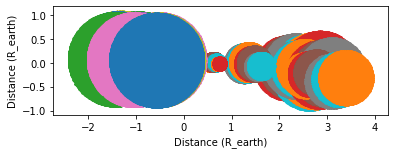

In [20]:
inname = 'theta_89_orientation.txt'
outname = 'theta_89_orientation_output.txt'
inputtxt = np.loadtxt(inname,skiprows=1,delimiter=' ',dtype={'names':('targSPH','targprofile','projSPH','projprofile','b','v_c','t','units_b','units_v_c','boxsize','densityfloor','hmax','filename'),'formats':('U256','U256','U256','U256',float,float,float,'U12','U12',float,float,float,'U256')})
writelines=np.array([])
for i in range(np.size(inputtxt)):
    #load target and projectile
    targetSPH,targetplanet,targetdata = loadPlanet(inputtxt['targSPH'][i],inputtxt['targprofile'][i])
    projSPH,projplanet,projdata = loadPlanet(inputtxt['projSPH'][i],inputtxt['projprofile'][i])
    
    # Collision parameters
    b = inputtxt['b'][i]                        #impact angle/parameter
    v_c = inputtxt['v_c'][i]                    #impact velocity (in units of v_esc or m/s)
    t = inputtxt['t'][i]                        #time to impact (in seconds)
    units_b = inputtxt['units_b'][i]            #"B" for angle, "b" for parameter
    units_v_c = inputtxt['units_v_c'][i]        #"v_esc" for scaled to escape velocity, "m/s" for m/s
    boxsize = inputtxt['boxsize'][i]*R_earth
    if inputtxt['densityfloor'][i] > 0:
        densityfloor = inputtxt['densityfloor'][i]*1.e3 #converting from g/cm^3 to kg/m^3
    else: densityfloor = None
    if inputtxt['hmax'][i] > 0:
        hmax = inputtxt['hmax'][i]
    else: hmax = None

    filename = inputtxt['filename'][i]         #hdf5 filename

    outstring=orientPlanets(filename,b=b,v_c=v_c,t=t,target=targetplanet,targetSPH=targetSPH,projectile=projplanet,projSPH=projSPH,units_b=units_b,units_v_c=units_v_c,boxsize=boxsize,densityfloor=densityfloor,hmax=hmax,saveoutput=False)
    writelines=np.append(writelines,outstring)
    
with open(outname,"w") as outfile:
    outfile.write("#filename M_t[M_earth] M_i[M_earth] R_t[R_earth] R_i[R_earth] b B[degrees] v/vesc v[km/s] t_impact[sec] h_max[R_earth] density_floor[g/cm^3] box_size[R_earth] TargetSPH Target_profile ImpactorSPH Impactor_profile ResidualVels \n")
    for i in range(np.size(inputtxt)):
        outfile.write(writelines[i]+'\n')

## Optional: make restart files for longer simulation runs
This section uses final snapshots from simulation runs to create ICs files for additional longer runs (such as restarting a graze-and-merge simulation that has not yet resolved). This is done by using SWIFT's select_output options to specify a time and snapshot label for each simulation snapshot such that the result is an uninterrupted time sequence of SWIFT snapshots.

**NOTE: The restarted output snapshots will *NOT* have leading zeros in their filenames! I.e., if a simulation is restarted from Snapshot_0123.hdf5, the following restarted output will begin with Snapshot_124.hdf5. Analysis codes will need to be flexible to account for leading zeros or lack thereof.**

#### Parameters for this notebook section:
 - `filename` - name of the output .hdf5 file to be used as a restart ICs file (does require .hdf5 file suffix), e.g. `restart_ICs.hdf5`
 - `SPH` - SWIFT snapshot object of the final snapshot .hdf5 file, generated using `loadPlanet(snapshotfile,init=False)`
 - `boxsize` boxsize for the restarted SWIFT simulation, defaults to the same boxsize as the snapshot to restart from
 - `duration` - time (in **hours**) to run the restarted simulation for, defaults to 48 hours
 - `freq` - time (in **seconds**) between SWIFT output snapshots after restarting, defaults to 600 (every 10 minutes)
 - `snapstart` - snapshot number of the final snapshot used as the initial conditions for the restart run, necessary to make sure the restarted snapshots follow the same numbering
 
#### Necessary configurations in the SWIFT yaml parameter file
1. Specify the restart ICs hdf5 file output by the below code as the initial conditions file.
1. Make sure all beginning time parameters are set to the time of the previous final snapshot (in internal units). These parameters are:
    1. `TimeIntegration:` `time_begin`
    1. `Snapshots:` `time_first`
    1. `Statistics:` `time_first`
1. Under `Snapshots` make the following changes:
    1. `output_list_on:    1`
    1. `select_output_on:  1`
    1. `output_list:       output_list.txt` (This is the .txt file generated by the below function that contains the list of snapshot times and numbers)
    1. `select_output:     select_output.yml`
1. Create a .yml file named `select_output.yml` that contains the following text (I think this file could technically be empty but it at least has to exist - have not fully tested but since we are not using DM particles this changes nothing):
    `Snapshot:`
        `Masses_DM: off`
1. Put the `select_output.yml` file and the `output_list.txt` file in the same directory as the parameter yaml file.

Another note: again, DOUBLE CHECK TO MAKE SURE THE SMOOTHING LENGTHS ARE CORRECT! They should now be on the order of 0.1 to 0.001 (in R_Earth units). If they're seemingly extremely small, just reload the snapshots and then run the following cells immediately after.

In [13]:
def restart_ICs(filename,SPH,boxsize=None,duration=48,freq=600,snapstart=0):
    if (os.path.isfile(filename)):
        input("Output file name exists already; press enter to delete it and write new file: "+filename)
        !del -f $filename
        
    if boxsize is None:
        boxsize=SPH.box_size_nonmks[0].value*R_earth,
    else:
        boxsize=boxsize*R_earth
    
    with h5py.File(filename, "w") as f:
        io.save_particle_data(
            f,
            SPH.pos.value-SPH.box_size.value/2,
            SPH.vel,
            SPH.m,
            SPH.h,
            SPH.rho,
            SPH.pres,
            SPH.u,
            SPH.mat_id,
            #A1_s=SPH.s,
            A1_id=SPH.part_id,
            boxsize=boxsize,
            file_to_SI=woma.Conversions(M_earth, R_earth, 1), # mass, length, time
            time=SPH.data.metadata.time.in_mks()
        )
    
    with open('output_list.txt','w') as outputlist:
        outputlist.write('# Time, Select Output, Label'+'\n')
        starttime=SPH.data.metadata.time.in_mks().value
        for i in range(0,duration*60*60//freq+1):
            outputlist.write('%d,'%(starttime+i*freq)+'Snapshot,'+'%d'%(snapstart+i+1)+'\n')
        

Could not find gas gamma, assuming 5./3.


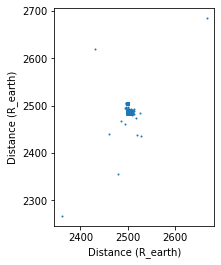

[5000. 5000. 5000.] Rearth

num_particle = 206353
boxsize      = 5e+03
mat_id       = 402 403 

Unit mass    = 5.97240e+27 g
Unit length  = 6.37100e+08 cm
Unit time    = 1.00000e+00 s

Min, max values (file units):
  pos = [2360.3, 2667.6,    2266.9, 2684.4,    2315.5, 2655.4]
  vel = [-0.00069801, 0.00076371,    -0.00068816, 0.00092808,    -0.00053794, 0.00052103]
  m = 5.7869e-06, 6.0973e-06
  rho = 3.0442e-05, 0.51329
  P = 4.1029e-18, 3.2621e-07
  u = 5.2118e-08, 1.1927e-06
  h = 0.027728, 0.43047

Saved "protoearth0.91x0.3v1.05th89.7_restart.hdf5"


In [19]:
snapshotfilename = 'protoearth0.91x0.3v1.05th89.7_0576.hdf5'
snapshotSPH,temp,snapshotdata = loadPlanet(snapshotfilename,plot=True,init=False)
print(snapshotSPH.box_size_nonmks)
restart_ICs('protoearth0.91x0.3v1.05th89.7_restart.hdf5',snapshotSPH,boxsize=5000,snapstart=576)